<center><font size=10>Data Science and Engineering</center></font>
<center><font size=6>Hotel Booking Cancellation Prediction using Data Science</center></font>

## Problem Definition

The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a **rise in inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need a Data Science-based solution to predict the likelihood of a booking being canceled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.

**liberary**

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as sfa
import statsmodels.api as sma


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.preprocessing import PowerTransformer

import random
import statsmodels.stats.weightstats as wstats
import statsmodels.stats.multicomp as multi
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow


from sklearn.metrics import r2_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold,cross_val_score,LeaveOneOut
from sklearn.metrics import confusion_matrix,classification_report,recall_score,precision_score,accuracy_score,f1_score
from sklearn.metrics import roc_auc_score,roc_curve,cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier,StackingClassifier
from xgboost import XGBClassifier,XGBRegressor


from warnings import filterwarnings
filterwarnings('ignore')


import pickle

**load data**

In [2]:
past_data=pd.read_csv('INNHotelsGroup_pastdata.csv')
new_data=pd.read_csv('INNHotelsGroup_newdata.csv')


In [3]:
past_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN


In [4]:
new_data.head(3)

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.0,1,0,2022-07-01,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.7,2,2,2022-07-01,0,2,Not Canceled
2,INNHG_128129,43,Online,1,126.9,2,1,2022-07-01,1,2,Not Canceled


In [5]:
past_data[past_data.duplicated(subset=['booking_id'])].sum()

booking_id                      0
lead_time                       0
market_segment_type             0
no_of_special_requests          0
avg_price_per_room            0.0
no_of_adults                    0
no_of_weekend_nights            0
arrival_date                    0
required_car_parking_space      0
no_of_week_nights               0
booking_status                  0
rebooked                        0
dtype: object

In [6]:
past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [7]:
print(f'past data rows:{past_data.shape[0]},columns:{past_data.shape[1]}')

past data rows:27093,columns:11


In [8]:
print(f'past data rows:{new_data.shape[0]},columns:{new_data.shape[1]}')

past data rows:3583,columns:10


# DATA EXPLORATION

#### HOW ANY CANCELED  BOOKING ARE REBOOKED 

* CANCELLED BOOKING

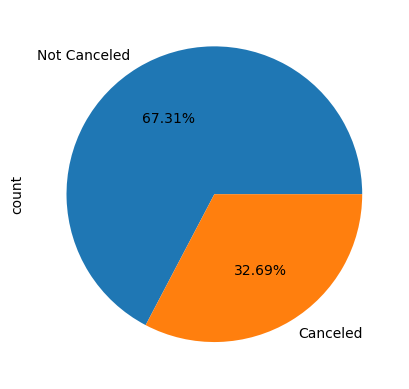

In [9]:
past_data['booking_status'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

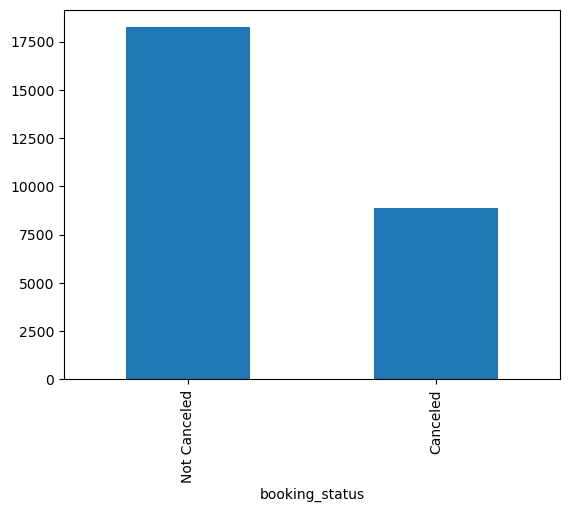

In [10]:
past_data['booking_status'].value_counts().plot(kind='bar')
plt.show()

**how many are rebooked out of canceled status**

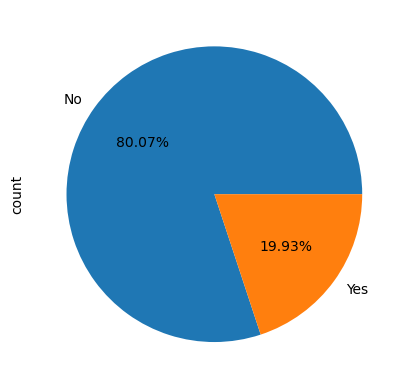

In [11]:
past_data[past_data['booking_status']=='Canceled']['rebooked'].value_counts().plot(kind='pie',autopct='%.2f%%')
plt.show()

**Inference**
* OUT OF TOTAL BOOKING MADE FROM 1-JAN-2021 TO 30-JUNE-2022  THERE ARE 33% booking are canceled
* ou of this `cancled booking only 20% are Rebooked` and `80% booking unable to Rebooked`and cause a huge loss

**UNIVARIENT ANALYSIS**

In [12]:
past_data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status', 'rebooked'],
      dtype='object')

In [13]:
num_col=['lead_time','avg_price_per_room']
cat_col=['market_segment_type', 'no_of_special_requests','no_of_adults', 'no_of_weekend_nights','required_car_parking_space','no_of_week_nights',
       'booking_status']

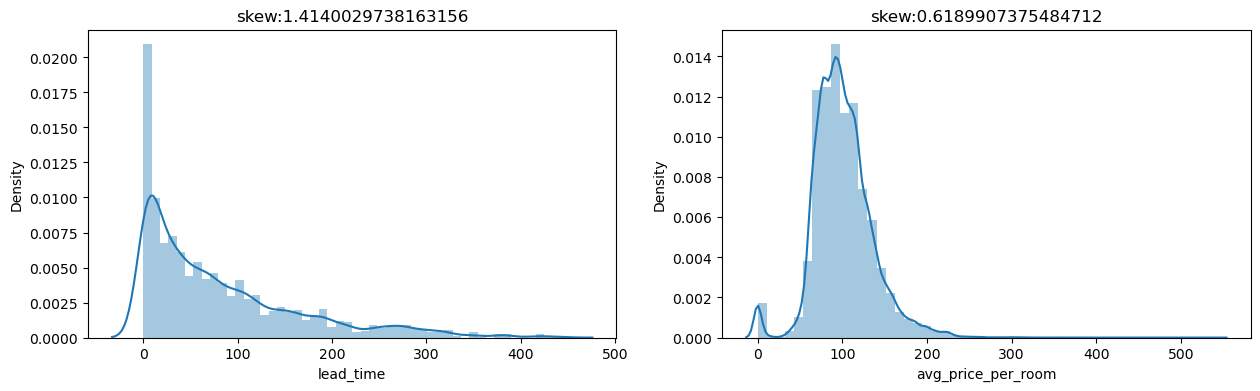

In [14]:
t=1
plt.figure(figsize=[15,4])
for i in num_col:
    plt.subplot(1,2,t)
    sns.distplot(past_data[i])
    plt.title(f'skew:{past_data[i].skew()}')
    t+=1
plt.tight_layout
plt.show()

**THIS IS RIGHT SKEWED**

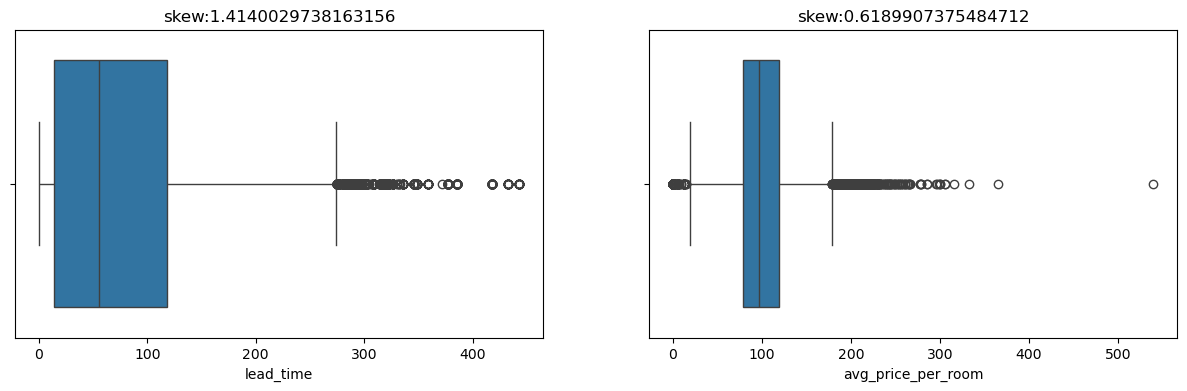

In [15]:
t=1
plt.figure(figsize=[15,4])
for i in num_col:
    plt.subplot(1,2,t)
    sns.boxplot(past_data[i],orient='h')
    plt.title(f'skew:{past_data[i].skew()}')
    t+=1
plt.tight_layout
plt.show()

**outliers in data set**

**inference:-**
* past data is `right skewed `& skewness happen because of `extreme outliers in upper tail`

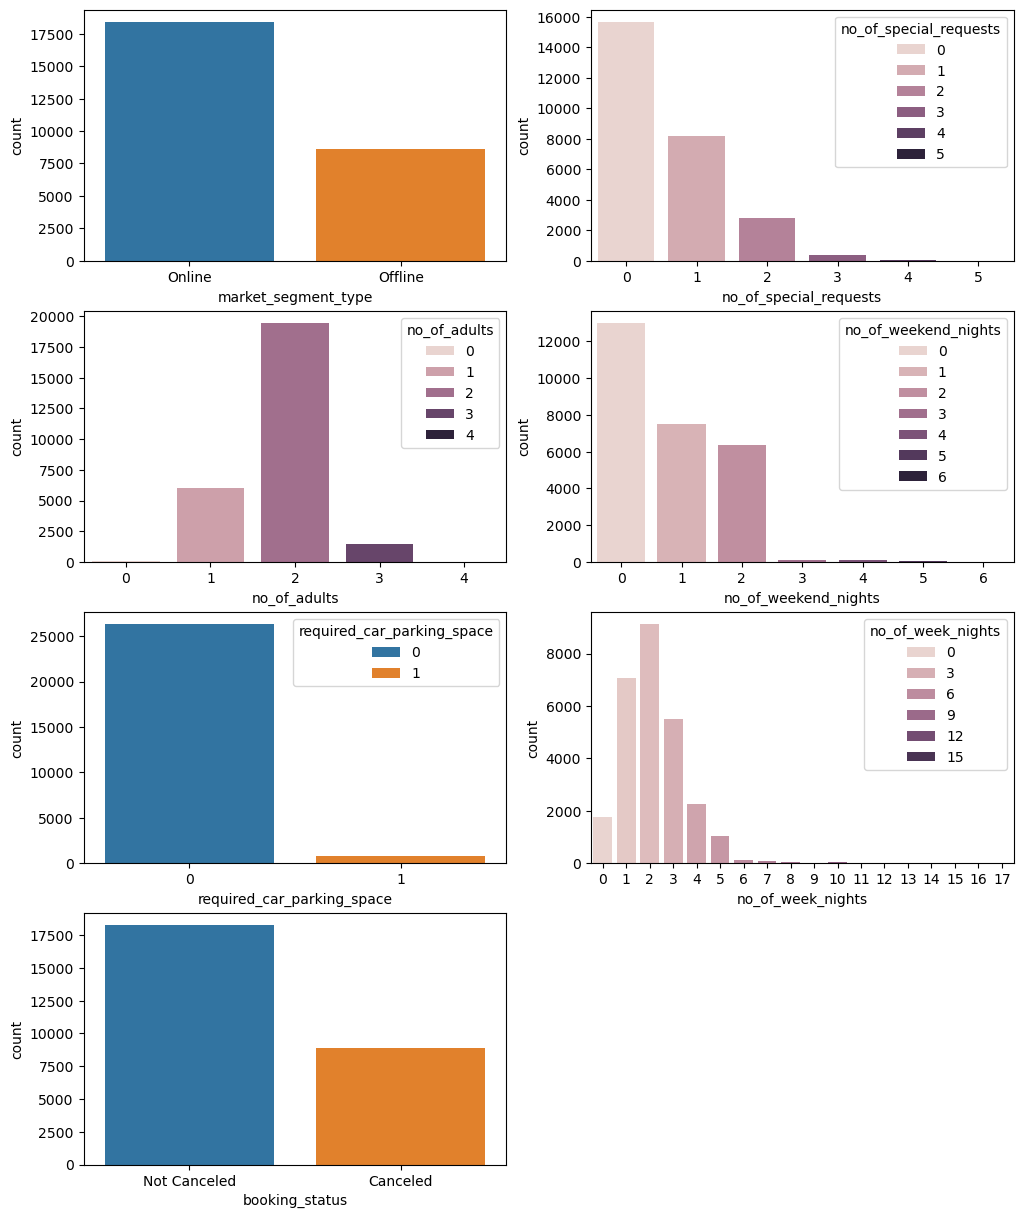

In [16]:
t=1
plt.figure(figsize=[12,15])
for i in cat_col:
    plt.subplot(4,2,t)
    sns.countplot(data=past_data,x=i,hue=i)
    t+=1
plt.show()

**CATEGORICAL INFRENCES**

* most of booking are `online`
* most of the guest `does not have special reqirements of car parking`
* most of booking made for `2 adults`
* most of booking include`0,1,2 weekend nights` & `1,2,3 weeknights`

**BIVARIENT ANALYSIS**

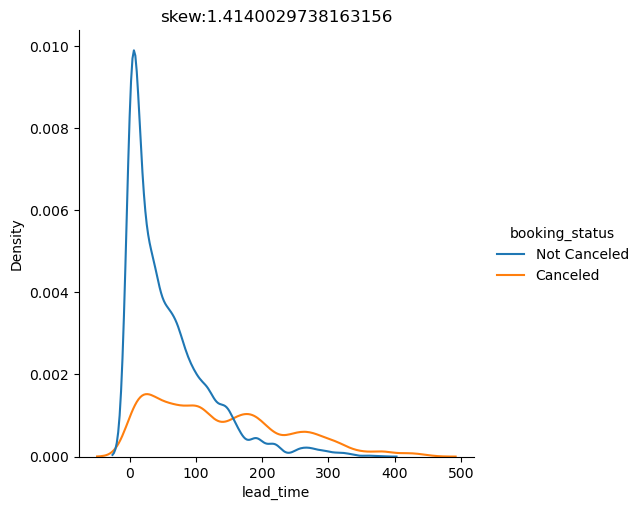

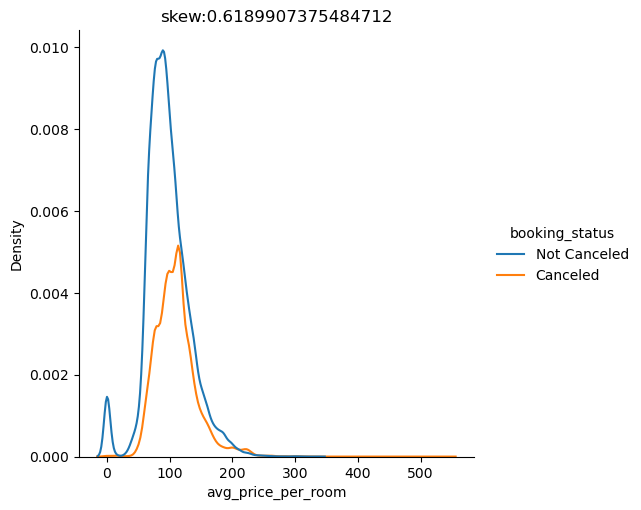

In [17]:
for i in num_col:
    sns.displot(data=past_data,x=i,kind='kde',hue='booking_status')
    plt.title(f'skew:{past_data[i].skew()}')
plt.tight_layout
plt.show()

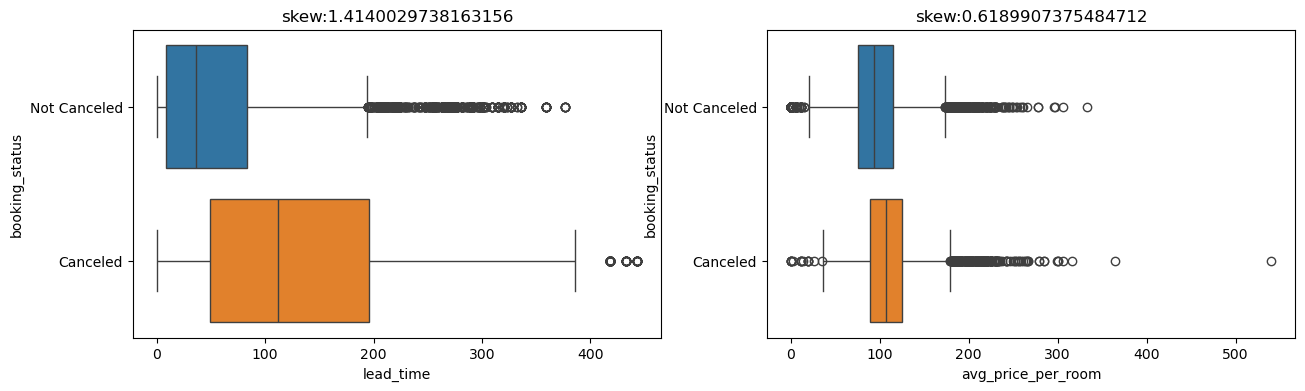

In [18]:
t=1
plt.figure(figsize=[15,4])
for i in num_col:
    plt.subplot(1,2,t)
    sns.boxplot(data=past_data,x=i,y='booking_status',hue='booking_status')
    plt.title(f'skew:{past_data[i].skew()}')
    t+=1
plt.tight_layout
plt.show()

**INFERENCES**
* booking with larger lead time high chance to be cancelled
* there are extreme outlier in avg room price where booking is cancelled
* booking with lead time greater than 400 get cancelled
* booking of avg room price greater 350 is cancelled

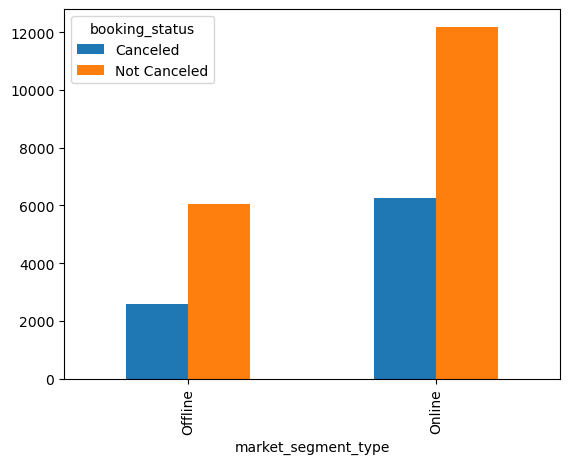

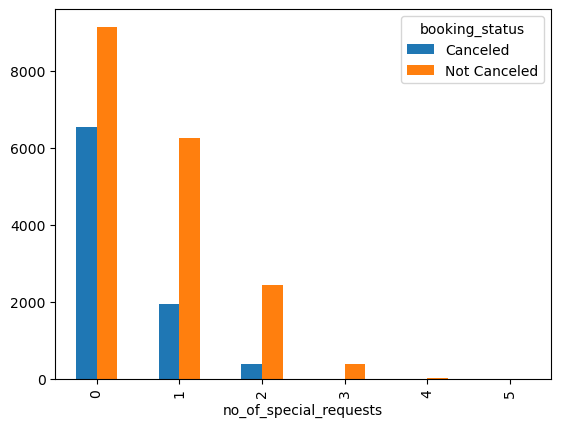

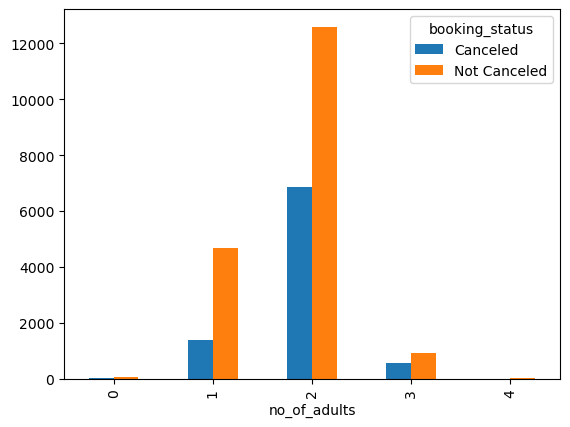

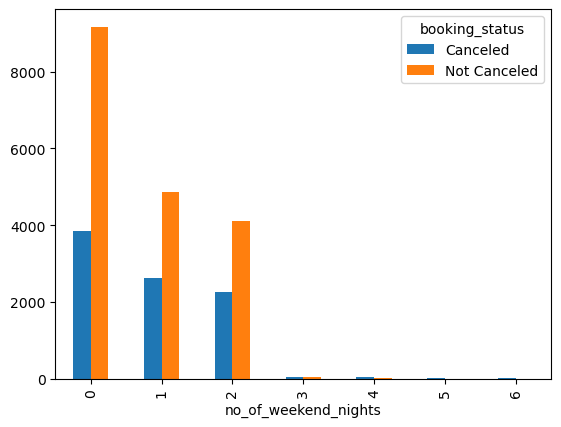

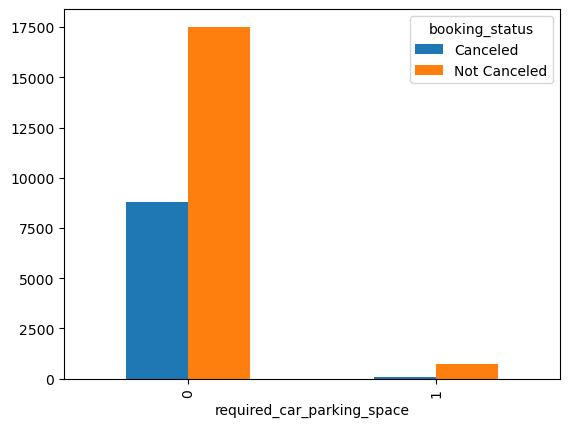

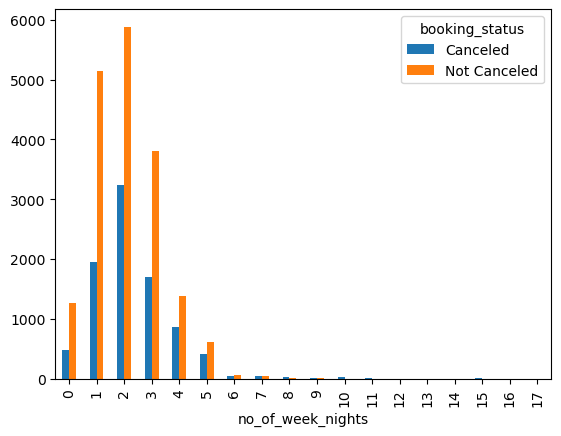

In [19]:
for i in cat_col:
    if i!='booking_status':
        pd.crosstab(index=past_data[i],columns=past_data['booking_status']).plot(kind='bar')
plt.show()

## INFRENCIAL STATISTICS..

In [20]:
samp1=past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2=past_data[past_data['booking_status']=='Not Canceled']['lead_time']

**assumption check**

* NORMALITY

In [21]:
print(stats.shapiro(past_data['lead_time']))

ShapiroResult(statistic=0.8447704281157536, pvalue=8.037706687701978e-94)


* varience check

In [22]:
print(stats.levene(samp1,samp2))

LeveneResult(statistic=3210.120590252021, pvalue=0.0)


**so we raject ho so that data is not normal and unequal varience---so we use mannwhitney**

**TEST**

In [23]:
tstats,p_val=stats.mannwhitneyu(samp1,samp2,alternative='less')

# **with 95% confidence level**

if p_val>0.05:
    print('fail to reject ho')
else:
    print('reject ho')


fail to reject ho


**hence we can say that mu1>mu2**

### DATA PREPROCESSING

**NULL VALUE---in both datasets**

In [24]:
past_data.isnull().sum()

lead_time                         0
market_segment_type               0
no_of_special_requests            0
avg_price_per_room                0
no_of_adults                      0
no_of_weekend_nights              0
arrival_date                      0
required_car_parking_space        0
no_of_week_nights                 0
booking_status                    0
rebooked                      18236
dtype: int64

In [25]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

**DUPLICATE ROWS IN PAST DATA**

###### WE CAN DROP THE COLIUMN REBOOKED AS IT IS NOT REQUIRED IN PREDICTION**

In [26]:
past_data.drop(columns=['rebooked'],inplace=True)

In [27]:
past_data.duplicated().sum()

8438

In [28]:
past_data.drop_duplicates(inplace=True)

In [29]:
past_data.shape

(18655, 10)

**CAP THE EXTREME OUTLIERS**

In [30]:
for i in num_col:
    q3,q1=np.percentile(past_data[i],[75,25])
    iqr=q3-q1
    ul,ll=q3+2*iqr,q1-2*iqr
    past_data[i]=past_data[i].apply(lambda x:ll if x<ll else ul if x>ul else x)

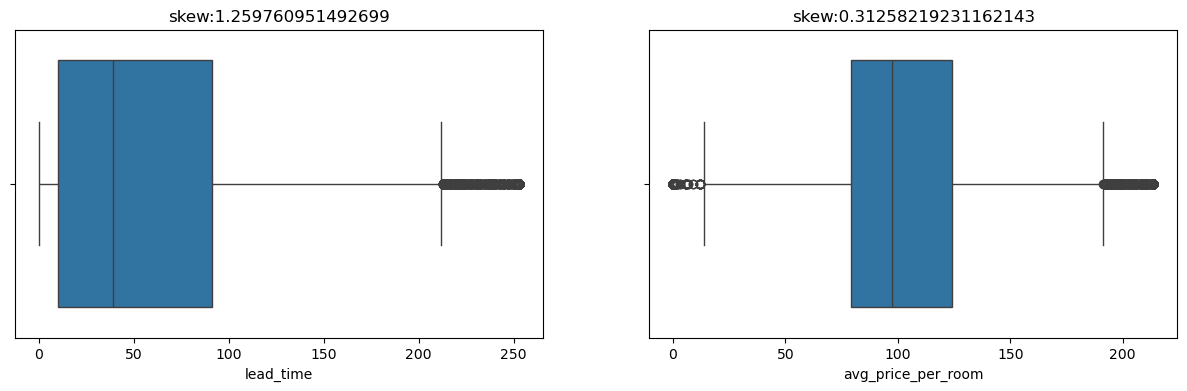

In [31]:
t=1
plt.figure(figsize=[15,4])
for i in num_col:
    plt.subplot(1,2,t)
    sns.boxplot(past_data[i],orient='h')
    plt.title(f'skew:{past_data[i].skew()}')
    t+=1
plt.tight_layout
plt.show()

--------

In [32]:
past_data.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0.0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34.0,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
INNHG_101036,24.0,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled
INNHG_101037,23.0,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled
INNHG_101038,46.0,Online,1,149.40,2,2,2021-01-01,0,3,Canceled


#### FEATURE ENGINNERING

**first take ARRIVAL DATE**

##### FOR PAST DATA

In [33]:
past_data['arrival_date']=pd.to_datetime(past_data['arrival_date'])
past_data['arrival_DAY']=past_data['arrival_date'].dt.day
past_data['arrival_MONTH']=past_data['arrival_date'].dt.month
past_data['arrival_YEAR']=past_data['arrival_date'].dt.weekday

##### FOR NEW DATA

In [ ]:
new_data['arrival_date']=pd.to_datetime(new_data['arrival_date'])
new_data['arrival_DAY']=new_data['arrival_date'].dt.day
new_data['arrival_MONTH']=new_data['arrival_date'].dt.month
new_data['arrival_YEAR']=new_data['arrival_date'].dt.weekday

**LETS DROP BOTH ARRIVAL DATE FROM THE PAST & NEW DATA**

In [35]:
past_data.drop(columns=['arrival_date'],inplace=True)
new_data.drop(columns=['arrival_date'],inplace=True)

In [36]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3583 entries, INNHG_128127 to INNHG_131709
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_time                   3583 non-null   int64  
 1   market_segment_type         3583 non-null   object 
 2   no_of_special_requests      3583 non-null   int64  
 3   avg_price_per_room          3583 non-null   float64
 4   no_of_adults                3583 non-null   int64  
 5   no_of_weekend_nights        3583 non-null   int64  
 6   required_car_parking_space  3583 non-null   int64  
 7   no_of_week_nights           3583 non-null   int64  
 8   booking_status              3583 non-null   object 
 9   arrival_DAY                 3583 non-null   int32  
 10  arrival_MONTH               3583 non-null   int32  
 11  arrival_YEAR                3583 non-null   int32  
dtypes: float64(1), int32(3), int64(6), object(2)
memory usage: 321.9+ KB


In [37]:
past_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18655 entries, INNHG_101034 to INNHG_128126
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   lead_time                   18655 non-null  float64
 1   market_segment_type         18655 non-null  object 
 2   no_of_special_requests      18655 non-null  int64  
 3   avg_price_per_room          18655 non-null  float64
 4   no_of_adults                18655 non-null  int64  
 5   no_of_weekend_nights        18655 non-null  int64  
 6   required_car_parking_space  18655 non-null  int64  
 7   no_of_week_nights           18655 non-null  int64  
 8   booking_status              18655 non-null  object 
 9   arrival_DAY                 18655 non-null  int32  
 10  arrival_MONTH               18655 non-null  int32  
 11  arrival_YEAR                18655 non-null  int32  
dtypes: float64(2), int32(3), int64(5), object(2)
memory usage: 2.1+ MB


# Encoding

**Encode MARKET-SEGMENT**

In [38]:
past_data['market_segment_type'].value_counts()

market_segment_type
Online     15529
Offline     3126
Name: count, dtype: int64

In [39]:
past_data['market_segment_type']=past_data['market_segment_type'].map({'Online':1,'Offline':0})
new_data['market_segment_type']=new_data['market_segment_type'].map({'Online':1,'Offline':0})

**ENCODE BOKKING-STATUS**

In [40]:
past_data['booking_status'].value_counts()

booking_status
Not Canceled    13270
Canceled         5385
Name: count, dtype: int64

In [41]:
past_data['booking_status']=past_data['booking_status'].map({'Canceled':1,'Not Canceled':0})
new_data['booking_status']=new_data['booking_status'].map({'Canceled':1,'Not Canceled':0})

--------

## TRAIN-TEST Split data**

In [42]:
y_train=past_data['booking_status']
x_train=past_data.drop(columns='booking_status')
y_test=new_data['booking_status']
x_test=new_data.drop(columns='booking_status')

In [43]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(18655, 11) (3583, 11) (18655,) (3583,)


## PREDICTIVE MODELLING

In [44]:
mod = []
accu = []
rec = []
pre = []
f1 = []
ckap = []
def model_validation(model,xtrain,ytrain,xtest,ytest):
    m = model
    m.fit(xtrain,ytrain)
    pred_h = m.predict(xtest)
    pred_s = m.predict_proba(xtest)[:,1]

    print('Confusion Matrix:\n',confusion_matrix(ytest,pred_h))
    print('\nClassifaction report:\n',classification_report(ytest,pred_h))

    fpr,tpr,thres = roc_curve(ytest,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],ls='--',color='red')
    plt.title(f'ROC AUC: {round(roc_auc_score(ytest,pred_s),2)}')
    plt.show()

    ans = input('Do you want to save the result? Y/N')
    if ans.lower()=='y':
        mod.append(str(model))
        accu.append(accuracy_score(ytest,pred_h))
        pre.append(round(precision_score(ytest,pred_h),2))
        rec.append(recall_score(ytest,pred_h))
        f1.append(f1_score(ytest,pred_h))
        ckap.append(cohen_kappa_score(ytest,pred_h))
        global scorecard
        scorecard = pd.DataFrame({'Model':mod,'Accuracy':accu,'Precesion':pre,'Recall':rec,
                                 'F1 Score':f1,'Cohen Kappa':ckap})
    else:
        return
    

In [45]:
def tuning_parameters(grid,estimator,x,y,score='f1'):
    gscv = GridSearchCV(estimator=estimator,param_grid=grid,verbose=1,scoring=score)
    gscv.fit(x,y)
    return gscv.best_params_

#### CLASS WEIGHTS

In [46]:
y_train.value_counts()

booking_status
0    13270
1     5385
Name: count, dtype: int64

In [47]:
weights=y_train.shape[0]/(2*y_train.value_counts()[0]),y_train.shape[0]/(2*y_train.value_counts()[1])

In [48]:
weights

(0.7029012810851545, 1.7321262766945218)

In [49]:
weights_dict={k:v for k,v in zip(range(2),weights)}

In [50]:
weights_dict

{0: 0.7029012810851545, 1: 1.7321262766945218}

## LOGISTIC

Confusion Matrix:
 [[2157  226]
 [ 565  635]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85      2383
           1       0.74      0.53      0.62      1200

    accuracy                           0.78      3583
   macro avg       0.76      0.72      0.73      3583
weighted avg       0.77      0.78      0.77      3583



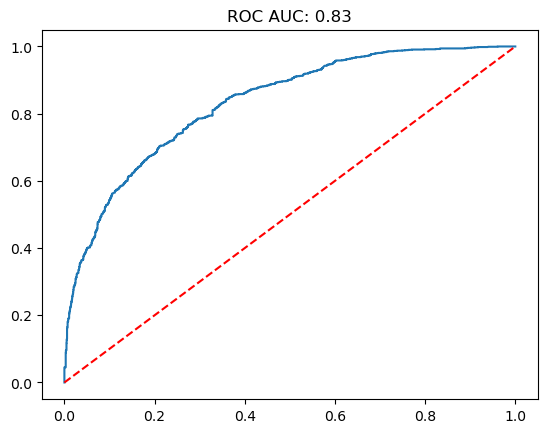

Do you want to save the result? Y/N y


In [51]:
model_validation(LogisticRegression(),x_train,y_train,x_test,y_test)

In [52]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.46708


**REGRESIION WITH ClaSS WEIGHT**

Confusion Matrix:
 [[1742  641]
 [ 290  910]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.86      0.73      0.79      2383
           1       0.59      0.76      0.66      1200

    accuracy                           0.74      3583
   macro avg       0.72      0.74      0.73      3583
weighted avg       0.77      0.74      0.75      3583



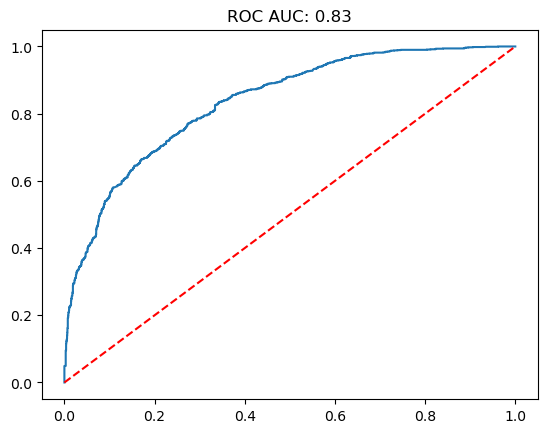

Do you want to save the result? Y/N y


In [53]:
model_validation(LogisticRegression(class_weight=weights_dict),x_train,y_train,x_test,y_test)

In [54]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221


# NAIVE-BASE

Confusion Matrix:
 [[1870  513]
 [ 439  761]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2383
           1       0.60      0.63      0.62      1200

    accuracy                           0.73      3583
   macro avg       0.70      0.71      0.71      3583
weighted avg       0.74      0.73      0.74      3583



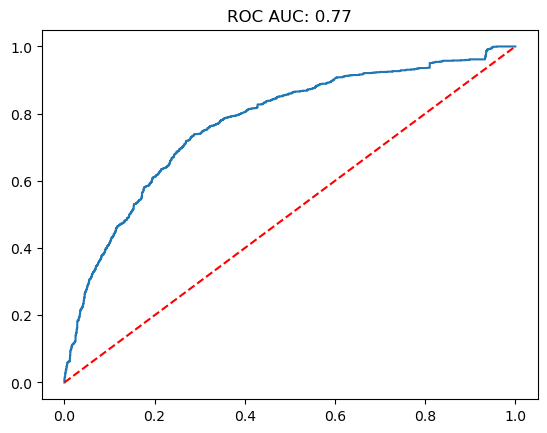

Do you want to save the result? Y/N y


In [55]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

In [56]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577


Confusion Matrix:
 [[1434  949]
 [ 333  867]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.81      0.60      0.69      2383
           1       0.48      0.72      0.57      1200

    accuracy                           0.64      3583
   macro avg       0.64      0.66      0.63      3583
weighted avg       0.70      0.64      0.65      3583



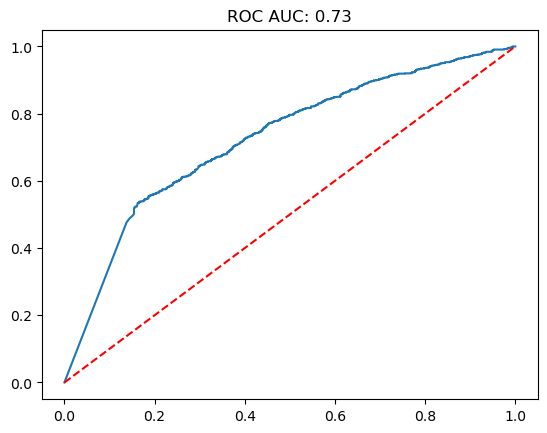

Do you want to save the result? Y/N y


In [57]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

In [58]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615


### DICISION TREE

In [59]:
best_dt=tuning_parameters(grid={'max_depth':[3,4,5,6,7,8,9,10]},estimator=DecisionTreeClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Confusion Matrix:
 [[1858  525]
 [ 267  933]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.78      0.82      2383
           1       0.64      0.78      0.70      1200

    accuracy                           0.78      3583
   macro avg       0.76      0.78      0.76      3583
weighted avg       0.80      0.78      0.78      3583



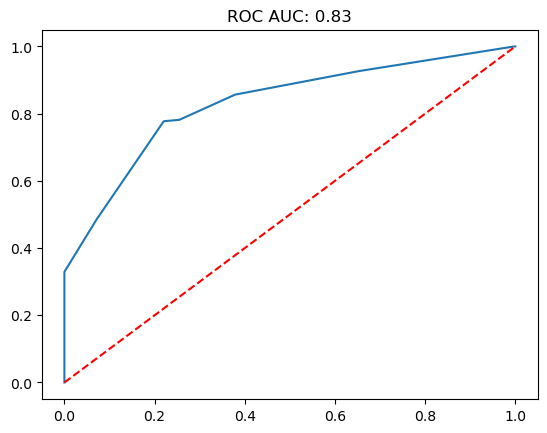

Do you want to save the result? Y/N y


In [60]:
model_validation(DecisionTreeClassifier(**best_dt),x_train,y_train,x_test,y_test)

In [61]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961


**with class weights**

In [62]:
best_dtc=tuning_parameters(grid={'max_depth':[3,4,5,6,7,8,9,10]},estimator=DecisionTreeClassifier(class_weight=weights_dict),x=x_train,y=y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Confusion Matrix:
 [[2130  253]
 [ 352  848]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      2383
           1       0.77      0.71      0.74      1200

    accuracy                           0.83      3583
   macro avg       0.81      0.80      0.81      3583
weighted avg       0.83      0.83      0.83      3583



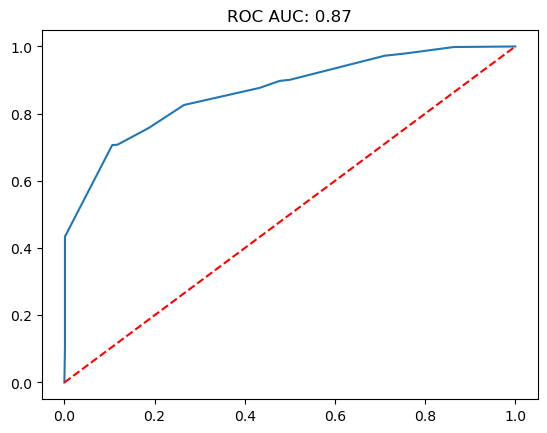

Do you want to save the result? Y/N y


In [63]:
model_validation(DecisionTreeClassifier(**best_dtc),x_train,y_train,x_test,y_test)

In [64]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052


## RANDOM FOREST

In [65]:
best_rf=tuning_parameters(grid={'max_depth':[3,4,5,6,7,8,9,10],'n_estimators':[50,70,80,90,100,120,150]},estimator=RandomForestClassifier(max_features=None),x=x_train,y=y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


Confusion Matrix:
 [[1975  408]
 [ 328  872]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      2383
           1       0.68      0.73      0.70      1200

    accuracy                           0.79      3583
   macro avg       0.77      0.78      0.77      3583
weighted avg       0.80      0.79      0.80      3583



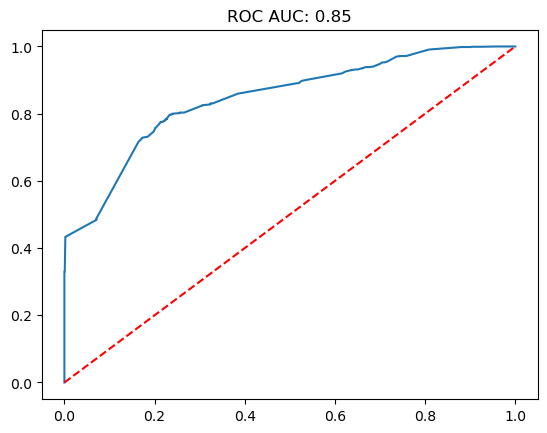

Do you want to save the result? Y/N y


In [66]:
model_validation(RandomForestClassifier(**best_rf,max_features=None),x_train,y_train,x_test,y_test)

In [67]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412


In [68]:
past_data['booking_status'].value_counts(normalize=True)

booking_status
0    0.711337
1    0.288663
Name: proportion, dtype: float64

**THERE ARE IMBAALANCE IN CLASSES OF BOOKING**

**WITH CLASS WEIGHTS**

In [88]:
best_rfc=tuning_parameters(grid={'max_depth':[3,4,5,6,7],'n_estimators':[80,100,120]},estimator=RandomForestClassifier(max_features=None),x=x_train,y=y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [89]:
best_rfc

{'max_depth': 3, 'n_estimators': 120}

Confusion Matrix:
 [[1720  663]
 [ 216  984]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.89      0.72      0.80      2383
           1       0.60      0.82      0.69      1200

    accuracy                           0.75      3583
   macro avg       0.74      0.77      0.74      3583
weighted avg       0.79      0.75      0.76      3583



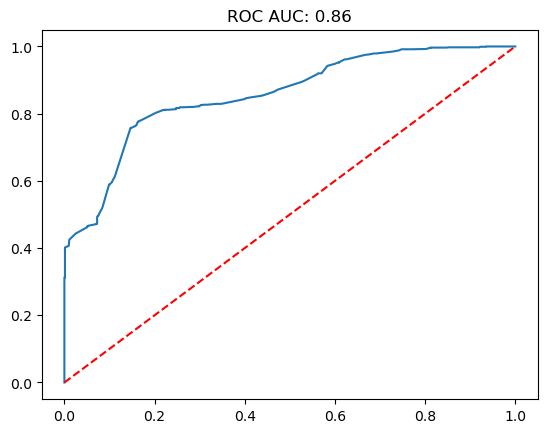

Do you want to save the result? Y/N y


In [94]:
model_validation(RandomForestClassifier(**best_rf,max_features=None,class_weight=weights_dict),x_train,y_train,x_test,y_test)

In [95]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


## ADA BOOST

In [73]:
best_ada=tuning_parameters(grid={'n_estimators':[50,70,100,120,150],'learning_rate':[0.1,0.5]},estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=weights_dict)),x=x_train,y=y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [74]:
best_ada

{'learning_rate': 0.5, 'n_estimators': 120}

Confusion Matrix:
 [[1808  575]
 [ 258  942]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      2383
           1       0.62      0.79      0.69      1200

    accuracy                           0.77      3583
   macro avg       0.75      0.77      0.75      3583
weighted avg       0.79      0.77      0.77      3583



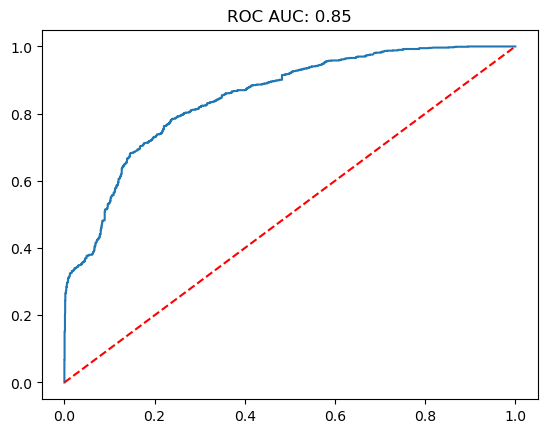

Do you want to save the result? Y/N y


In [75]:
model_validation(AdaBoostClassifier(**best_ada),x_train,y_train,x_test,y_test)

In [76]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250


## GRADIENT DESCENT boost

In [77]:
best_gdm=tuning_parameters(grid={'n_estimators':[50,70,100,120,150],'learning_rate':[0.1,0.5],'max_depth':[3,5,7]},estimator=GradientBoostingClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Confusion Matrix:
 [[2143  240]
 [ 319  881]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2383
           1       0.79      0.73      0.76      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.82      0.82      3583
weighted avg       0.84      0.84      0.84      3583



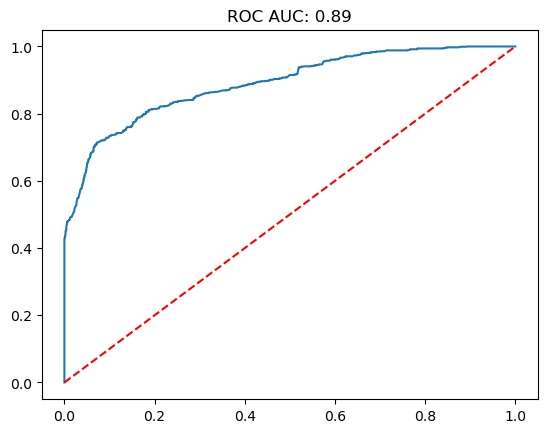

Do you want to save the result? Y/N Y


In [82]:
model_validation(GradientBoostingClassifier(**best_gdm),x_train,y_train,x_test,y_test)

In [83]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


## XG BOOST 

In [78]:
best_xgb=tuning_parameters(grid={'n_estimators':[70,100,120,150],'learning_rate':[0.1,0.5],'gamma':[1,2,3]},estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [79]:
best_xgb

{'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 70}

Confusion Matrix:
 [[2063  320]
 [ 312  888]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87      2383
           1       0.74      0.74      0.74      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



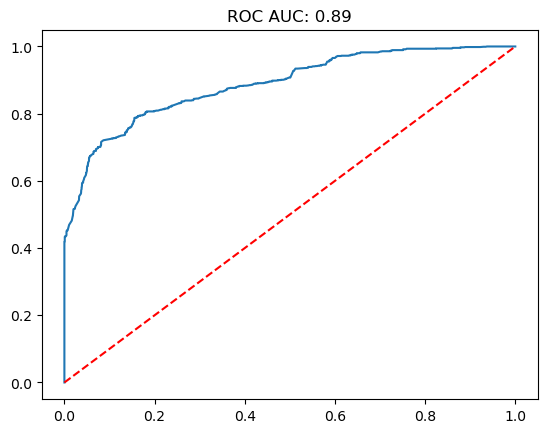

Do you want to save the result? Y/N Y


In [80]:
model_validation(XGBClassifier(**best_gdm),x_train,y_train,x_test,y_test)

In [81]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715


## VOTING()

Confusion Matrix:
 [[2018  365]
 [ 283  917]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      2383
           1       0.72      0.76      0.74      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.81      0.80      3583
weighted avg       0.82      0.82      0.82      3583



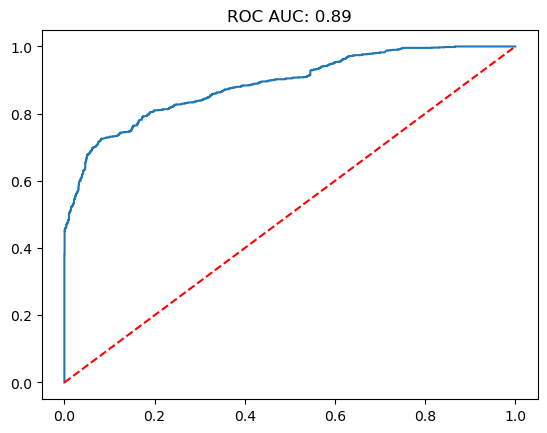

Do you want to save the result? Y/N y


In [97]:
base_estimators =  [('DT',DecisionTreeClassifier(**best_dt,class_weight=weights_dict)),
                    ('RF',RandomForestClassifier(**best_rf,class_weight=weights_dict)),
                    ('GBM',GradientBoostingClassifier(**best_gdm)),
                    ('XGB',XGBClassifier(**best_xgb))]
model_validation(VotingClassifier(estimators=base_estimators,voting='soft'),x_train,y_train,x_test,y_test)

In [98]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


## STACKING()

Confusion Matrix:
 [[2129  254]
 [ 476  724]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      2383
           1       0.74      0.60      0.66      1200

    accuracy                           0.80      3583
   macro avg       0.78      0.75      0.76      3583
weighted avg       0.79      0.80      0.79      3583



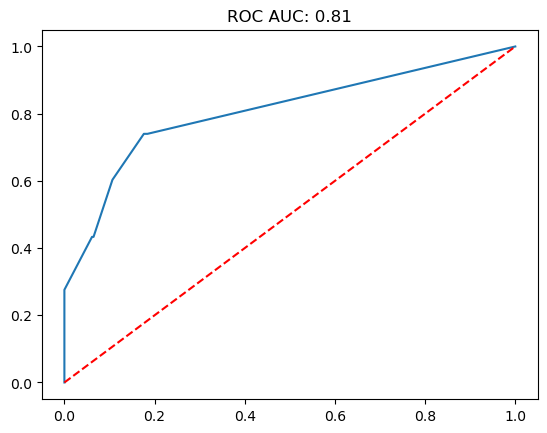

Do you want to save the result? Y/N y


In [99]:
model_validation(StackingClassifier(estimators=base_estimators,final_estimator=DecisionTreeClassifier(max_depth=3,class_weight=weights_dict)),x_train,y_train,x_test,y_test)

Confusion Matrix:
 [[2195  188]
 [ 426  774]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      2383
           1       0.80      0.65      0.72      1200

    accuracy                           0.83      3583
   macro avg       0.82      0.78      0.80      3583
weighted avg       0.83      0.83      0.82      3583



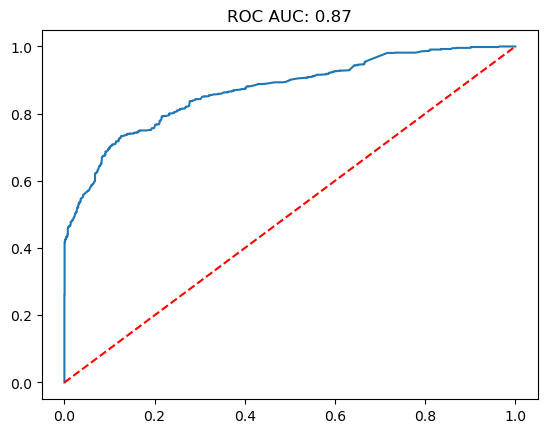

Do you want to save the result? Y/N Y


In [101]:
model_validation(StackingClassifier(estimators=base_estimators,final_estimator=(max_depth=3,class_weight=weights_dict)),x_train,y_train,x_test,y_test)

In [102]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


## Best MODEL

In [103]:
best_xgb

{'gamma': 3, 'learning_rate': 0.1, 'n_estimators': 70}

In [116]:
grid={'gamma':[3,4,5,6],
     'learning_rate':[0.5,0.2,0.1,1],
     'n_estimators':[65,70,75,80,85,100]}

In [117]:
final_xgb=tuning_parameters(grid=grid,estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [121]:
final_xgb

{'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 75}

Confusion Matrix:
 [[2039  344]
 [ 307  893]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      2383
           1       0.72      0.74      0.73      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



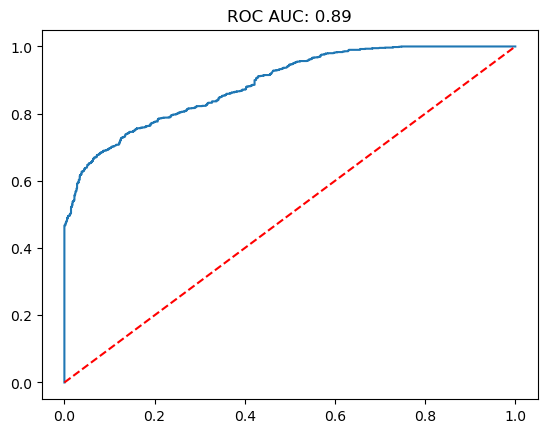

Do you want to save the result? Y/N y


In [122]:
model_validation(XGBClassifier(**final_xgb),x_train,y_train,x_test,y_test)

In [123]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


**use another parameters for this**

In [109]:
grid={'max_depth':[3,4,5,6,7],
     'learning_rate':[0.5,0.2,0.1,0.09,0.08],
     'n_estimators':[65,67,70,72,75,80,85,100]}

In [110]:
final_xgb2=tuning_parameters(grid=grid,estimator=XGBClassifier(),x=x_train,y=y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Confusion Matrix:
 [[2059  324]
 [ 306  894]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87      2383
           1       0.73      0.74      0.74      1200

    accuracy                           0.82      3583
   macro avg       0.80      0.80      0.80      3583
weighted avg       0.82      0.82      0.82      3583



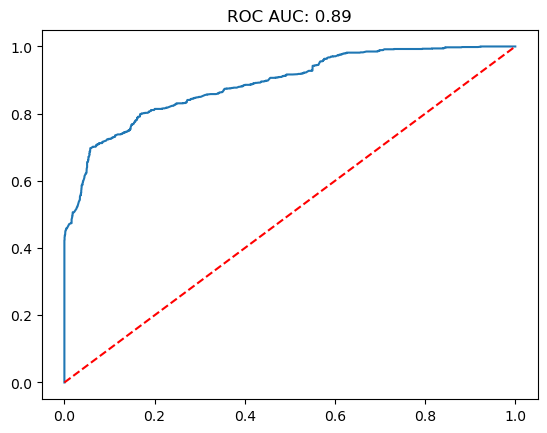

Do you want to save the result? Y/N y


In [118]:
model_validation(XGBClassifier(**final_xgb2),x_train,y_train,x_test,y_test)

In [119]:
final_xgb2

{'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 80}

In [120]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


# FINAL MODEL

In [126]:
final_model=GradientBoostingClassifier(**best_gdm)

In [127]:
final_model.fit(x_test,y_test)

GradientBoostingClassifier(n_estimators=50)

Confusion Matrix:
 [[2143  240]
 [ 319  881]]

Classifaction report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2383
           1       0.79      0.73      0.76      1200

    accuracy                           0.84      3583
   macro avg       0.83      0.82      0.82      3583
weighted avg       0.84      0.84      0.84      3583



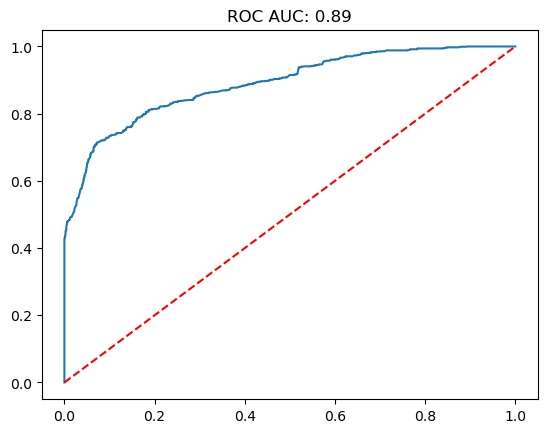

Do you want to save the result? Y/N y


In [128]:
model_validation(final_model,x_train,y_train,x_test,y_test)

In [129]:
scorecard

,Model,Accuracy,Precesion,Recall,F1 Score,Cohen Kappa
0,LogisticRegression(),0.779235,0.74,0.529167,0.616206,0.467080
1,LogisticRegression(class_weight={0: 0.70290128...,0.740162,0.59,0.758333,0.661578,0.456221
2,GaussianNB(),0.734301,0.60,0.634167,0.615198,0.412577
3,MultinomialNB(),0.642199,0.48,0.722500,0.574934,0.287615
4,DecisionTreeClassifier(max_depth=3),0.778956,0.64,0.777500,0.702032,0.528961
5,DecisionTreeClassifier(max_depth=4),0.831147,0.77,0.706667,0.737071,0.613052
6,"RandomForestClassifier(max_depth=3, max_featur...",0.794586,0.68,0.726667,0.703226,0.546412
7,"AdaBoostClassifier(learning_rate=0.5, n_estima...",0.767513,0.62,0.785000,0.693412,0.510250
8,"XGBClassifier(base_score=None, booster=None, c...",0.823611,0.74,0.740000,0.737542,0.604715
9,GradientBoostingClassifier(n_estimators=50),0.843985,0.79,0.734167,0.759156,0.643976


## BUSSINESS INTERPRET:

In [134]:
fi=final_model.feature_importances_

In [138]:
fi_data=pd.DataFrame({'FEATURE_importance':fi},index=x_train.columns).sort_values(by='FEATURE_importance',ascending=False)

In [ ]:
fi_data

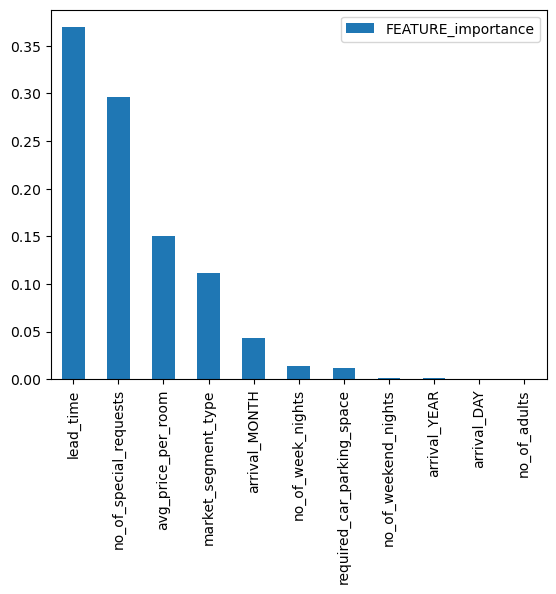

In [143]:
fi_data.plot(kind='bar')
plt.show()

**INTERPRETATIONS**

* `LEAD_TIME` is the most imopoertant feature in the data
* `NO OF SPECIAL REQUEST` HAVE ALSO SIME SIGNIFICANT EFFECT ON REBOOKING 

# DEPLOYEMENT

In [130]:
# save the final model as a pickle file

In [133]:
with open('final_model_gradient.pkl','wb') as file:
    pickle.dump(final_model,file)